In [1]:
!pip install transformers
!pip install tiktoken
!pip install protobuf
!pip install sentencepiece
!pip install matplotlib
!pip install jiwer

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com

[notice] A new release of pip is available: 24.0 -> 25.1.1
[notice] To update, run: python -m pip install --upgrade pip
Looking in indexes: https://py

In [ ]:
import torch
from torch import nn
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, random_split
from torch.amp import autocast, GradScaler
import torchvision
from torch.optim.lr_scheduler import ReduceLROnPlateau

from transformers import VivitConfig, VivitModel

# from tqdm.notebook import tqdm
from tqdm import tqdm
from PIL import Image
import json
import os
import numpy as np
import random

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from jiwer import wer, cer

from ray import tune, air
from ray.tune.schedulers import ASHAScheduler
from ray.tune import Callback, RunConfig, FailureConfig
from ray.tune.search.optuna import OptunaSearch
import gc

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-05-23 06:18:51,659	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2025-05-23 06:18:52,084	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
random.seed(42)

In [4]:
word_to_idx = { '<p>':0, '<s>':1, '</s>':2}
idx_to_word = ['<p>', '<s>', '</s>']

arr_train = np.loadtxt("/home/jovyan/datasets/phoenix2014-release/phoenix-2014-multisigner/annotations/manual/train.corpus.csv", delimiter='|', dtype='str')
arr_train = np.delete(arr_train,0,0)
arr_test = np.loadtxt("/home/jovyan/datasets/phoenix2014-release/phoenix-2014-multisigner/annotations/manual/test.corpus.csv", delimiter='|', dtype='str')
arr_test = np.delete(arr_test,0,0)
arr_dev = np.loadtxt("/home/jovyan/datasets/phoenix2014-release/phoenix-2014-multisigner/annotations/manual/dev.corpus.csv", delimiter='|', dtype='str')
arr_dev = np.delete(arr_dev,0,0)

arr = np.concatenate((arr_train, arr_test, arr_dev), axis=0)

for sentence in arr:
    for word in sentence[3].split(' '):
        if word not in idx_to_word:
            idx_to_word.append(word)
            word_to_idx[word] = len(idx_to_word)-1

In [5]:
len(idx_to_word), len(word_to_idx)

(1299, 1299)

In [6]:
class rwth_phoenix(Dataset):
    def __init__(self, csv, data_path, frame_transform, video_transform, input_fps, output_fps, max_frames, stride, word_dict):

        temp = np.loadtxt(csv, delimiter='|', dtype='str')
        self.csv = np.delete(temp, 0, 0)
        self.word_dict = word_dict
        self.data_path = data_path

        self.frame_transform = frame_transform
        self.video_transform = video_transform

        self.input_fps = input_fps
        self.output_fps = output_fps
        self.max_frames = max_frames
        self.stride = stride


    def __len__(self):
        return len(self.csv)


    def __getitem__(self, idx):
        folder = self.csv[idx][1].split('/')
        label = self.csv[idx][3].split(' ')

        words = []
        for word in label:
            words.append(self.word_dict[word])
        label = torch.tensor(words)
        image_folder_path = os.path.join(self.data_path, folder[0], folder[1])

        images = os.listdir(image_folder_path)
        end = len(images)

        step = self.input_fps/random.choice(self.output_fps)
        image_list = []
        if int(end//step +1) <= self.max_frames:
            frame_num, num = 0, 0
            while frame_num < end:
                num+=1
                if self.stride and num%self.stride == 0:
                    image_list.append(str(int(frame_num))+'a')

                else:
                    img = Image.open(os.path.join(image_folder_path, images[int(frame_num)]))
                    tensor_img = self.frame_transform(img)
                    image_list.append(tensor_img)
                frame_num += step

            c, h, w = image_list[-1].shape
            while len(image_list) < self.max_frames:
                image_list.append(torch.zeros(c,h,w))

            tensor_video = torch.stack(image_list[:self.max_frames])
            tensor_video = self.video_transform(tensor_video)

        else:
            frame_positions = np.linspace(0, end, self.max_frames, endpoint=False)
            num = 0
            for n in frame_positions:
                num+=1
                if self.stride and num%self.stride == 0:
                    image_list.append(str(int(n))+'a')

                else:
                    img = Image.open(os.path.join(image_folder_path, images[int(n)]))
                    tensor_img = self.frame_transform(img)
                    image_list.append(tensor_img)

            tensor_video = torch.stack(image_list[:self.max_frames])
            tensor_video = self.video_transform(tensor_video)


        return tensor_video, label

In [7]:
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomCrop((248,200)),
    transforms.Resize((224,224)),
    transforms.RandomRotation((-5,5))
])

video_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0.5)
])

In [8]:
image_test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224,224)),
])

video_test_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(0)
])

In [9]:
max_frames = 32

In [10]:
train_dataset = rwth_phoenix(csv="/home/jovyan/datasets/phoenix2014-release/phoenix-2014-multisigner/annotations/manual/train.corpus.csv",
                       data_path="/home/jovyan/datasets/phoenix2014-release/phoenix-2014-multisigner/features/fullFrame-210x260px/train",
                        frame_transform=image_transform , video_transform=video_transform, input_fps=25, output_fps=list(range(4,10)), max_frames=max_frames, stride=0, word_dict=word_to_idx)

test_dataset = rwth_phoenix(csv="/home/jovyan/datasets/phoenix2014-release/phoenix-2014-multisigner/annotations/manual/test.corpus.csv",
                       data_path="/home/jovyan/datasets/phoenix2014-release/phoenix-2014-multisigner/features/fullFrame-210x260px/test",
                        frame_transform=image_test_transform , video_transform=video_test_transform, input_fps=25, output_fps=list(range(4,10)), max_frames=max_frames, stride=0, word_dict=word_to_idx)

dev_dataset = rwth_phoenix(csv="/home/jovyan/datasets/phoenix2014-release/phoenix-2014-multisigner/annotations/manual/dev.corpus.csv",
                       data_path="/home/jovyan/datasets/phoenix2014-release/phoenix-2014-multisigner/features/fullFrame-210x260px/dev",
                        frame_transform=image_test_transform , video_transform=video_test_transform, input_fps=25, output_fps=list(range(4,10)), max_frames=max_frames, stride=0, word_dict=word_to_idx)

In [11]:
train_dataset[0][0].shape

torch.Size([32, 3, 224, 224])

In [12]:
def collate_fn(batch):
    sos_token = 1
    eos_token = 2

    vid, labels = zip(*batch)
    vid = torch.stack(vid)

    sequence_lens = [len(label) for label in labels]
    max_len = max(sequence_lens) + 2

    # Pad labels with SOS and EOS tokens
    y_input = torch.full((len(labels), max_len), fill_value=0, dtype=torch.long)
    y_target = torch.full((len(labels), max_len), fill_value=0, dtype=torch.long)

    for i, label in enumerate(labels):
        y_input[i, 0] = sos_token
        y_input[i, 1:len(label) + 1] = label
        y_target[i, 0:len(label)] = label
        y_target[i, len(label)] = eos_token

    return vid, y_input, y_target

In [13]:
train_dataloader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=9, collate_fn=collate_fn,prefetch_factor=5,num_workers=14, pin_memory=True)
test_dataloader = DataLoader(dataset=test_dataset, shuffle=True, batch_size=9, collate_fn=collate_fn,prefetch_factor=5,num_workers=14, pin_memory=True)
dev_dataloader = DataLoader(dataset=dev_dataset, shuffle=True, batch_size=9, collate_fn=collate_fn,prefetch_factor=5,num_workers=14, pin_memory=True)

In [14]:
vid, y_label, y_target = next(iter(train_dataloader))

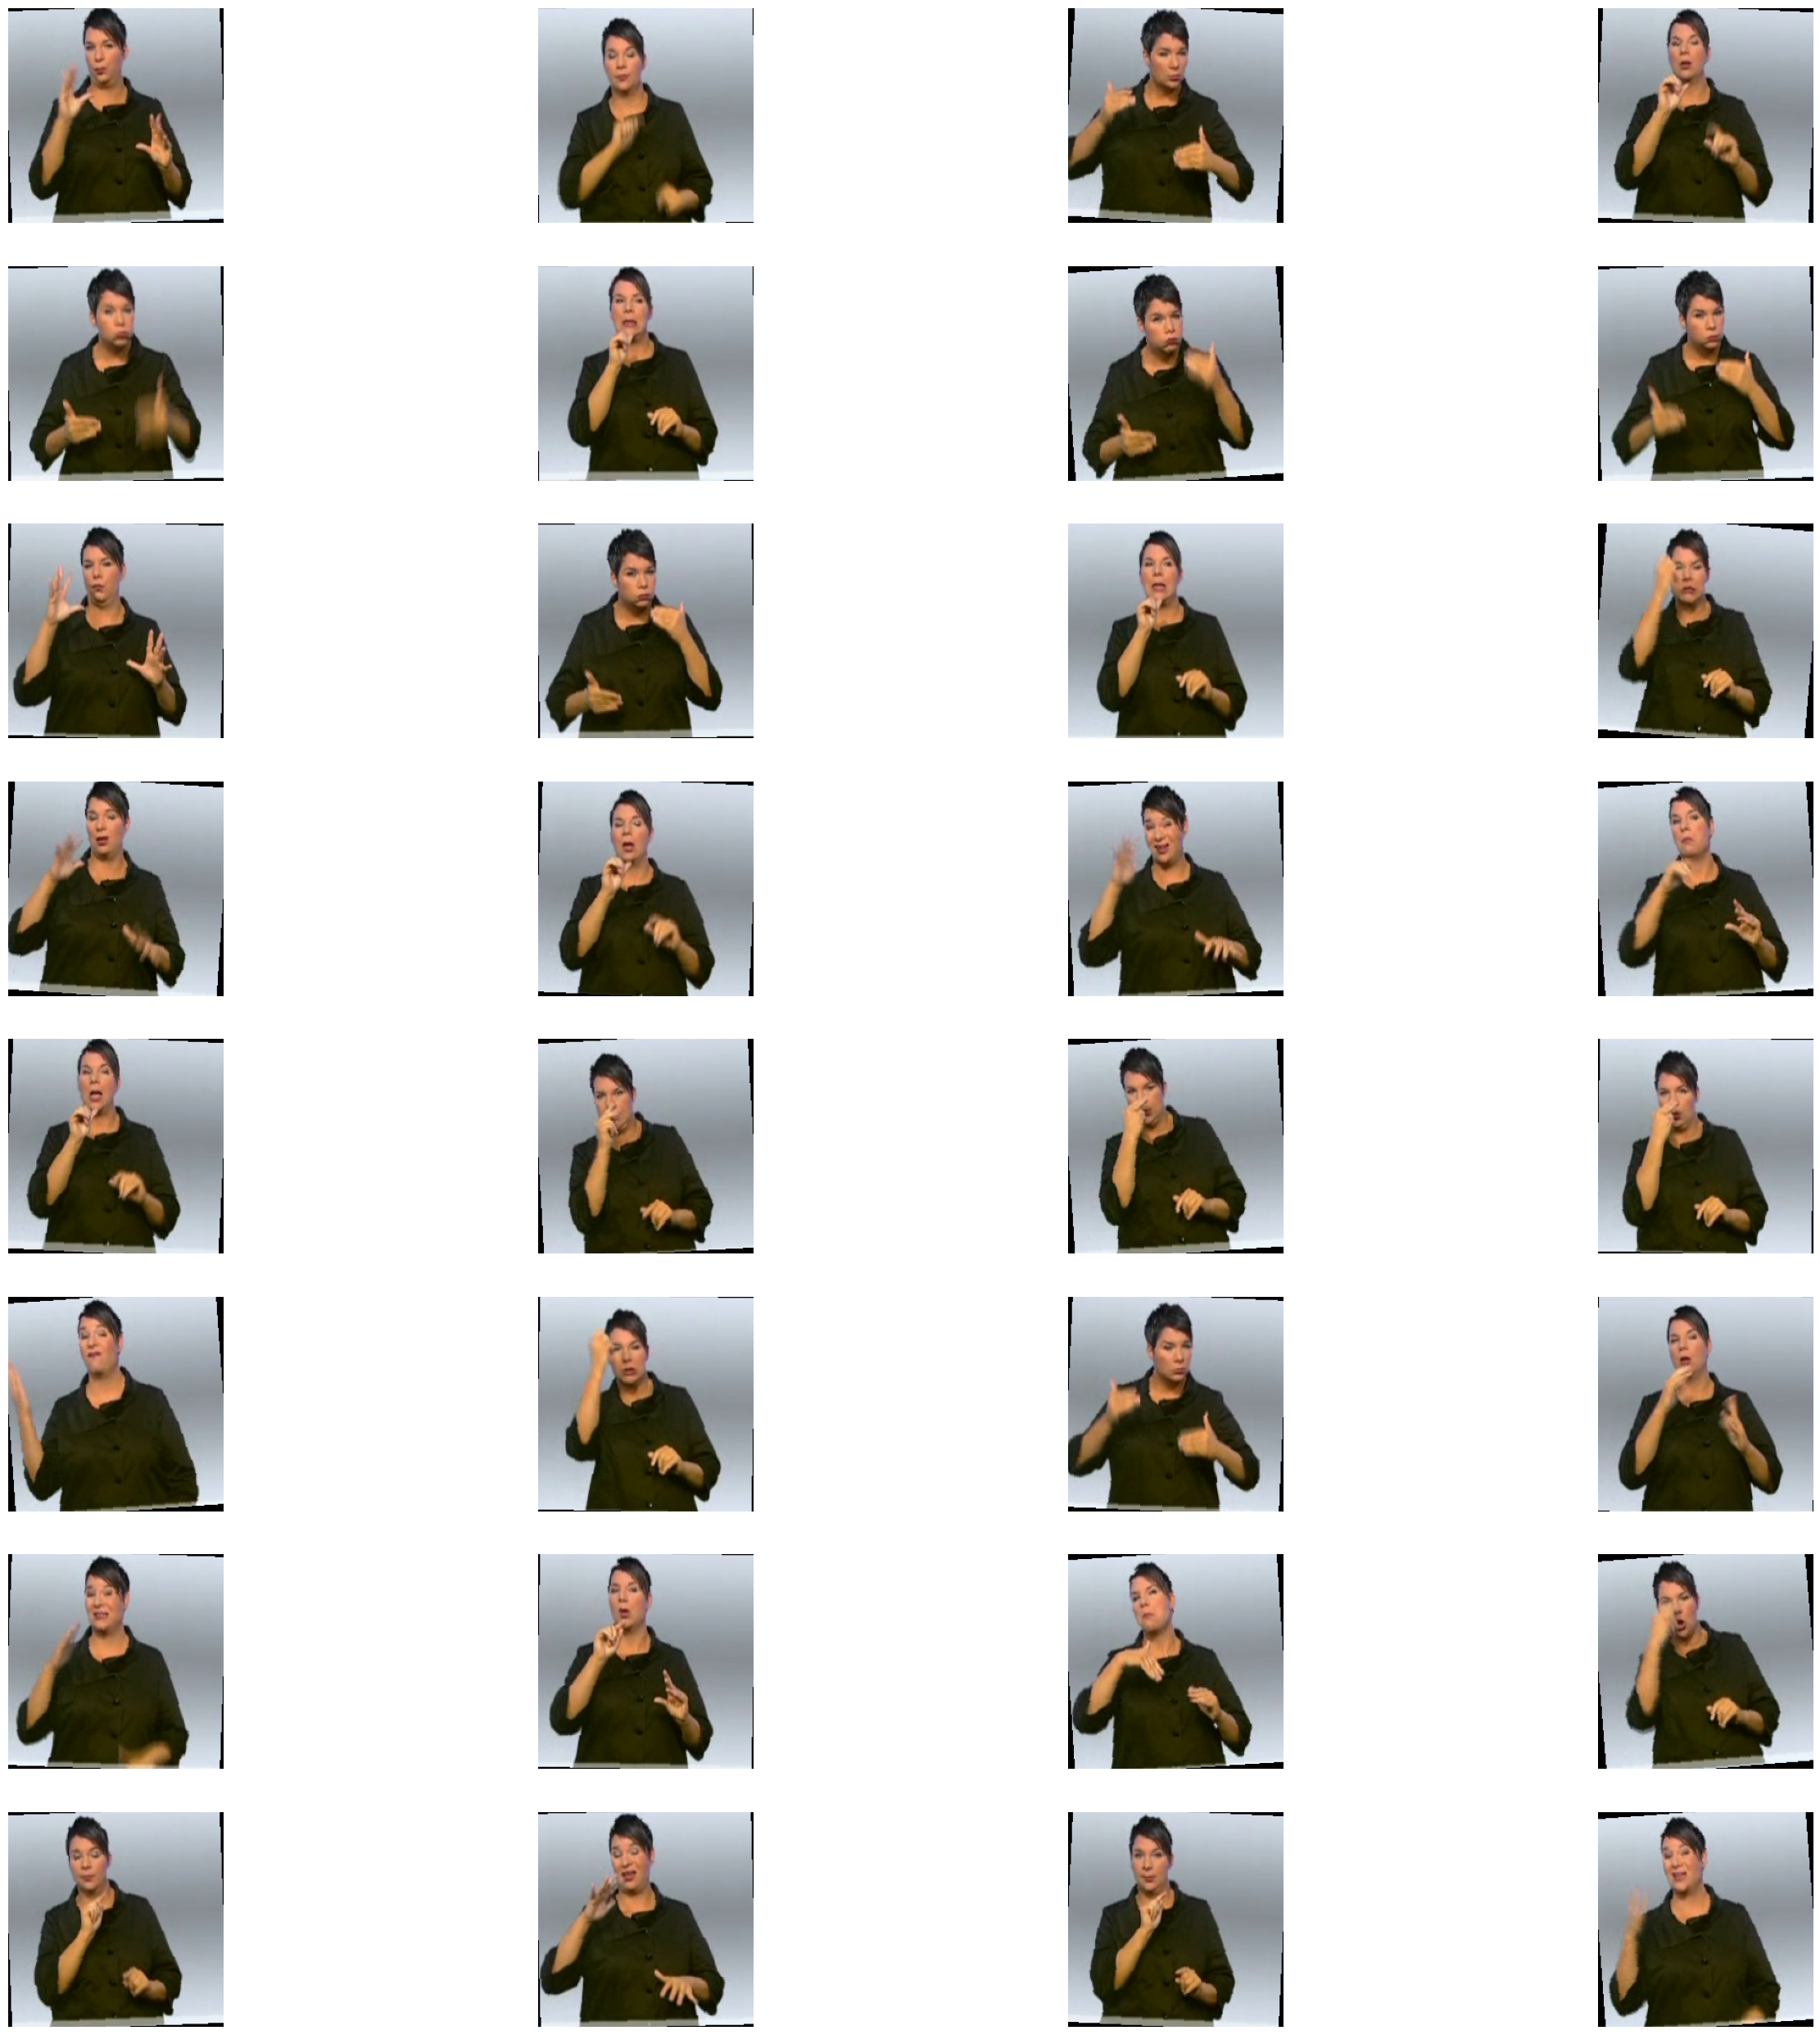

In [15]:
def show_sequence(sequence, NUM_FRAMES):
    columns = 4
    rows = (NUM_FRAMES + 1) // (columns)
    fig = plt.figure(figsize=(32, (16 // columns) * rows))
    gs = gridspec.GridSpec(rows, columns)
    for j in range(rows * columns):
        plt.subplot(gs[j])
        plt.axis("off")
        frames = sequence[j].permute(1,2,0).numpy()
        frames = frames/ frames.max()
        plt.imshow(frames)

    plt.show()

show_sequence(vid[3], 32)

In [16]:
class ViViT_SLR(nn.Module):
    def __init__(self,
                 vivit_config=VivitConfig(),
                 vocab_size=len(idx_to_word),
                 d_model=768,
                 nhead=8,
                 num_decoder_layers=4,
                 dim_feedforward=3072,
                 dropout=0.1,
                 batch_first=True,
                 num_heads=4,
                 pad_token=0,
                 sos_token=1,
                 eos_token=2,
                 residual_ratio=0,
                 max_pred=512):

        super(ViViT_SLR, self).__init__()

        # self.vivit = VivitModel(vivit_config)
        self.vivit = VivitModel.from_pretrained("google/vivit-b-16x2-kinetics400", attn_implementation="sdpa", torch_dtype=torch.float32)
        r3d_18 = torchvision.models.video.r3d_18(pretrained=True)
        self.r3d_18 = nn.Sequential(
            r3d_18.stem,
            r3d_18.layer1,
            r3d_18.layer2,
            r3d_18.layer3,
            nn.Conv3d(256, 512, kernel_size=(2, 1, 1), stride=(2, 1, 1))
        )
        self.cross_attn = nn.MultiheadAttention(embed_dim=768, num_heads=num_heads, batch_first=batch_first)

        self.linear = nn.Sequential(
            nn.Linear(in_features=512, out_features=640),
            nn.ReLU(),
            nn.Linear(in_features=640, out_features=768)
        )

        self.non_linear = nn.Sequential(
            nn.Linear(in_features=512, out_features=640),
            nn.ReLU(),
            nn.Linear(in_features=640, out_features=768)
        )
        self.linear = nn.Linear(512, 768)
        
        self.residual_ratio = residual_ratio
        
        self.normalize = nn.LayerNorm(768)

        decoder_layer = nn.TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=batch_first)
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_decoder_layers)

        self.pad_token = pad_token
        self.sos_token = sos_token
        self.eos_token = eos_token
        self.vocab_size = vocab_size

        self.embedding = nn.Embedding(vocab_size, d_model, padding_idx=pad_token)
        self.max_pred = max_pred

        self.fc_out = nn.Linear(d_model, vocab_size)

        self.init_weights()


    def forward(self, img, y_tokens):

        
        encoded_output1 = self.vivit(img).last_hidden_state
        encoded_output2 = self.r3d_18(img.permute(0,2,1,3,4))
        encoded_output2 = encoded_output2.permute(0,2,3,4,1)
        encoded_output2 = encoded_output2.view(-1, 28*28*4,512)
        encoded_output2 = self.residual_ratio * self.linear(encoded_output2) + (1 - self.residual_ratio) * self.non_linear(encoded_output2)
        encoded_output1 = self.normalize(encoded_output1)
        encoded_output2 = self.normalize(encoded_output2)

        attn_output, _ = self.cross_attn(query=encoded_output1[:, :3136, :], key=encoded_output2[:, :3136, :], value=encoded_output1[:, :3136, :])

        # print("Encoded Output 1 (ViViT)")
        # print("Min:", encoded_output1.min().item())
        # print("Max:", encoded_output1.max().item())
        # print("Mean:", encoded_output1.mean().item())
        # print("Std Dev:", encoded_output1.std().item())
        # print("-" * 30)

        # print("Encoded Output 2 (r3d_18)")
        # print("Min:", encoded_output2.min().item())
        # print("Max:", encoded_output2.max().item())
        # print("Mean:", encoded_output2.mean().item())
        # print("Std Dev:", encoded_output2.std().item())
        # print("-" * 30)

        # print("Cross Attention Output")
        # print("Min:", attn_output.min().item())
        # print("Max:", attn_output.max().item())
        # print("Mean:", attn_output.mean().item())
        # print("Std Dev:", attn_output.std().item())
        # print("-" * 30)


        if y_tokens.shape[-1] == 2:
            # all_logits = torch.zeros(self.vocab_size).unsqueeze(0).unsqueeze(0).to(device)

            for i in range(self.max_pred-2):
                y_embedded = self.embedding(y_tokens)
                tgt_seq_len = y_embedded.shape[1]
                tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_seq_len).to(y_embedded.device)

                tgt_key_padding_mask = (y_tokens == self.pad_token)

                decoded_output = self.decoder(y_embedded, attn_output, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)
                logit = self.fc_out(decoded_output)
                # all_logits = torch.cat([all_logits, logit[:,-1,:].unsqueeze(0)], dim=-2)


                last_output_token = logit[:,-1,:].argmax(1).unsqueeze(0)
                y_tokens = torch.cat([y_tokens, last_output_token], dim=1)
                # y_tokens = logit[:,-1,:].argmax(1).unsqueeze(0)
                print(y_tokens)

                if (last_output_token == self.eos_token).all():
                    return y_tokens, logit

            else:
                y_tokens = torch.cat([y_tokens, torch.tensor([[self.eos_token]]).to(device)], dim=1)
                return y_tokens, logit

        else:
            y_embedded = self.embedding(y_tokens)

            tgt_seq_len = y_embedded.shape[1]
            tgt_mask = nn.Transformer.generate_square_subsequent_mask(tgt_seq_len).to(y_embedded.device)

            tgt_key_padding_mask = (y_tokens == self.pad_token)

            decoded_output = self.decoder(y_embedded, attn_output, tgt_mask=tgt_mask, tgt_key_padding_mask=tgt_key_padding_mask)

            logit = self.fc_out(decoded_output)

            return logit

    def init_weights(self):
        # Embedding
        nn.init.normal_(self.embedding.weight, mean=0.0, std=0.02)
        if self.embedding.padding_idx is not None:
            with torch.no_grad():
                self.embedding.weight[self.embedding.padding_idx].fill_(0)

        # Output Linear
        nn.init.xavier_uniform_(self.fc_out.weight)
        if self.fc_out.bias is not None:
            nn.init.constant_(self.fc_out.bias, 0)

        # Decoder layers
        for layer in self.decoder.layers:
            # Self-attention
            nn.init.xavier_uniform_(layer.self_attn.in_proj_weight)
            if layer.self_attn.in_proj_bias is not None:
                nn.init.constant_(layer.self_attn.in_proj_bias, 0)
            # Cross-attention
            nn.init.xavier_uniform_(layer.multihead_attn.in_proj_weight)
            if layer.multihead_attn.in_proj_bias is not None:
                nn.init.constant_(layer.multihead_attn.in_proj_bias, 0)
            # Linear layers
            nn.init.xavier_uniform_(layer.linear1.weight)
            nn.init.xavier_uniform_(layer.linear2.weight)
            if layer.linear1.bias is not None:
                nn.init.constant_(layer.linear1.bias, 0)
            if layer.linear2.bias is not None:
                nn.init.constant_(layer.linear2.bias, 0)
            # LayerNorm
            nn.init.constant_(layer.norm1.weight, 1)
            nn.init.constant_(layer.norm1.bias, 0)
            nn.init.constant_(layer.norm2.weight, 1)
            nn.init.constant_(layer.norm2.bias, 0)
            if hasattr(layer, 'norm3'):
                nn.init.constant_(layer.norm3.weight, 1)
                nn.init.constant_(layer.norm3.bias, 0)


In [17]:
from torch.amp import autocast, GradScaler
scaler = GradScaler('cuda')

def decode_token(tensor, idx_to_char=idx_to_word):
    n = tensor.shape[0]
    text = []
    for i in range(n):
        st = ''
        for token in tensor[i]:
            if token == 2:
                break
            st += idx_to_char[token.item()]
        text.append(st)
    return text

def train_step(model, optimizer, dataloader, loss_fn, epoch):
    model.train()
    train_loss, total_correct_wer = 0, 0

    for X, y_input, y_target in dataloader:
        X, y_input, y_target = X.to(device), y_input.to(device), y_target.to(device)

        with autocast('cuda'):
            y_logit = model(X, y_input)

            if y_logit.isnan().any():
                print("ABORT!!!! \nNan found in y_logit!")
                
            loss = loss_fn(y_logit.permute(0,2,1), y_target)
            train_loss += loss.item()

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()

        y_pred = torch.argmax(y_logit, dim=2)
        total_correct_wer += wer(decode_token(y_target), decode_token(y_pred))
        del X, y_input, y_target, y_logit, loss, y_pred

    acc_wer = (total_correct_wer / len(dataloader)) * 100
    avg_loss = train_loss / len(dataloader)

    print(f"Epoch {epoch} | Train Loss: {avg_loss:.4f} | Train WER: {acc_wer:.2f}%")
    return avg_loss, acc_wer

def test_step(model, loss_fn, epoch, dataloader, scheduler):
    model.eval()
    test_loss, total_correct_wer = 0, 0

    for X, y_input, y_target in dataloader:
        X, y_input, y_target = X.to(device), y_input.to(device), y_target.to(device)

        with autocast('cuda'):
            y_logit = model(X, y_input)

            if y_logit.isnan().any():
                print("ABORT!!!! \nNan found in y_logit!")

            loss = loss_fn(y_logit.permute(0,2,1), y_target)
            test_loss += loss.item()

        y_pred = torch.argmax(y_logit, dim=2)
        total_correct_wer += wer(decode_token(y_target), decode_token(y_pred))
        del X, y_input, y_target, y_logit, loss, y_pred

    acc_wer = (total_correct_wer / len(dataloader)) * 100
    avg_loss = test_loss / len(dataloader)

    if isinstance(scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
        scheduler.step(avg_loss)

    print(f"Epoch {epoch} | Test Loss: {avg_loss:.4f} | Test WER: {acc_wer:.2f}%")
    return avg_loss, acc_wer

In [18]:
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)
# device = "cuda"

# model = ViViT_SLR().to(device)
# # checkpoint = torch.load(f="/kaggle/input/vvocr_final/pytorch/default/1/VVOCR.pth")
# # new_state_dict = checkpoint["model_state_dict"]
# # model.load_state_dict(new_state_dict, strict=True)
# # model = nn.DataParallel(model)
# # checkpoint = torch.load(f="/kaggle/input/vvocr/pytorch/default/1/VVOCR.pth")
# # from collections import OrderedDict

# # new_state_dict = OrderedDict()
# # for k, v in checkpoint['model_state_dict'].items():
# #     new_key = k.replace("module.", "")  # strip 'module.' prefix
# #     new_state_dict[new_key] = v
# # model.load_state_dict(new_state_dict, strict=True)
# loss_fn = nn.CrossEntropyLoss(ignore_index=0, label_smoothing=0.1)
# optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
# scheduler = ReduceLROnPlateau(
#     optimizer,
#     mode='min',
#     factor=0.5,
#     patience=2,
#     min_lr=1e-6,
# )

In [19]:
# X, y_input, y_target = next(iter(train_dataloader))

In [20]:
# y_input[0][0].unsqueeze(0).unsqueeze(0).shape

In [21]:
# y_logits = model(X[0].unsqueeze(0),y_input[0][0].unsqueeze(0).unsqueeze(0))

In [22]:
# y_logits

In [23]:
# epochs = 10
# torch.manual_seed(42)
# torch.cuda.manual_seed(42)
# for epoch in range(epochs):
#   train_step(model=model,
#              optimizer=optimizer,
#              loss_fn=loss_fn,
#              epoch=epoch,
#              dataloader=train_dataloader)
#   test_step(model=model,
#             loss_fn=loss_fn,
#             epoch=epoch,
#             dataloader=test_dataloader,
#             scheduler=scheduler
#            )

In [ ]:
search_space = {
    "lr": tune.loguniform(1e-5, 1e-3),
    "weight_decay": tune.uniform(0.0, 0.05),
    "batch_size": tune.choice([2, 4]),
    "nhead": tune.choice([4, 8, 12]),
    "dim_feedforward": tune.choice([2048, 3072, 4096]),
    "dropout": tune.uniform(0.1, 0.4),
    "num_decoder_layers": tune.choice([3, 4, 5, 6]),
    "residual_ratio": tune.uniform(0, 1),
    "num_heads": tune.choice([4, 8, 12]),
    "epochs": 15
}

In [ ]:
class temp_counter():
    count = 0

In [ ]:
def train_tune(config, checkpoint_dir=None):
    model = ViViT_SLR(
        nhead=config["nhead"],
        dim_feedforward=config["dim_feedforward"],
        dropout=config["dropout"],
        num_decoder_layers=config["num_decoder_layers"],
        residual_ratio=config["residual_ratio"],
        num_heads=config["num_heads"]
    ).to(device)
#     print(type(model))
#     model = nn.DataParallel(model)
#     print(type(model))

    optimizer = torch.optim.AdamW(
        model.parameters(), lr=config["lr"], weight_decay=config["weight_decay"]
    )

    # 💡 Note: mode should be "min" for loss
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer,
        mode='min',
        factor=0.5,
        patience=2,
        min_lr=1e-6, 
        verbose=True
    )

    loss_fn = nn.CrossEntropyLoss(ignore_index=0, label_smoothing=0.1)
    train_dataloader = DataLoader(dataset=train_dataset, shuffle=True, batch_size=config["batch_size"], collate_fn=collate_fn, prefetch_factor=4, num_workers=4)
    test_dataloader = DataLoader(dataset=test_dataset, shuffle=False, batch_size=config["batch_size"], collate_fn=collate_fn, prefetch_factor=4, num_workers=4)

    try:
        for epoch in range(config["epochs"]):
            train_step(model=model,
                optimizer=optimizer,
                loss_fn=loss_fn,
                epoch=epoch,
                dataloader=train_dataloader,
                )

            val_loss, val_acc =   test_step(model=model,
                                    loss_fn=loss_fn,
                                    epoch=epoch,
                                    dataloader=test_dataloader,
                                    scheduler=scheduler
                                    )
            
            if epoch == config["epochs"] - 1:
                checkpoint_dir = "/workspace/SLR/checkpoints"
                dictionary = {
                    'nhead':config["nhead"],
                    'dim_feedforward':config["dim_feedforward"],
                    'dropout':config["dropout"],
                    'num_decoder_layers':config["num_decoder_layers"],
                    'residual_ratio':config["residual_ratio"],
                    'num_heads':config["num_heads"],
                    'weights':model.state_dict()
                }
                best_model_path = os.path.join(checkpoint_dir, f"{temp_counter.count}.pt")
                temp_counter.count += 1
                torch.save(dictionary, best_model_path)

            tune.report({"val_loss": val_loss, "val_accuracy": val_acc})


    except RuntimeError as e:
        if "out of memory" in str(e):
            print("CUDA OOM. Skipping trial.")
            gc.collect()
            torch.cuda.empty_cache()
            tune.report(val_loss=9999.0, val_accuracy=0.0)
        else:
            raise
    
    gc.collect()
    torch.cuda.empty_cache()
    

In [26]:
class SimpleLoggerCallback(Callback):
    def on_trial_result(self, iteration, trials, trial, result, **info):
        print(f"[Trial {trial.trial_id}] Epoch {result['training_iteration']} - "
              f"Val Loss: {result['val_loss']:.4f}, Val Acc: {result['val_accuracy']:.2f}")

In [ ]:
absolute_path = os.path.abspath("ray_results")

tuner = tune.Tuner(
    tune.with_resources(train_tune, resources={"cpu": 4, "gpu": 1}),
    param_space=search_space,
    tune_config=tune.TuneConfig(
        num_samples=30,
        metric="val_accuracy",
        mode="max",
        scheduler=ASHAScheduler(max_t=15, grace_period=4),
        max_concurrent_trials=1,
        trial_dirname_creator=lambda trial: f"trial_{trial.trial_id}",
        trial_name_creator=lambda trial: f"trial_{trial.trial_id}",
    ),
    run_config=air.RunConfig(
        name="vivit_r3d_tuning",
        storage_path=f"file://{absolute_path}", 
        failure_config=FailureConfig(max_failures=3),
        callbacks=[SimpleLoggerCallback()]
    )
)

tuner.fit()

(raylet) Warning: The actor ImplicitFunc is very large (19 MiB). Check that its definition is not implicitly capturing a large array or other object in scope. Tip: use ray.put() to put large objects in the Ray object store.


(train_tune pid=71046) Some weights of VivitModel were not initialized from the model checkpoint at google/vivit-b-16x2-kinetics400 and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
(train_tune pid=71046) You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
(train_tune pid=71046) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
(train_tune pid=71046)   warnings.warn(
(train_tune pid=71046) /usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=R3D_18_Weights.KINETICS400_V1`. You can also use `weights=R3D_18_Weights.DEFAULT` to get the most up-to-date wei

In [4]:
import os
import json
import pandas as pd

# Path to the parent directory containing all trial folders
parent_dir = "ray_results/vivit_r3d_tuning"

# List all trial directories
trial_dirs = [
    os.path.join(parent_dir, d)
    for d in os.listdir(parent_dir)
    if os.path.isdir(os.path.join(parent_dir, d))
]

records = []
for trial_dir in trial_dirs:
    result_path = os.path.join(trial_dir, "result.json")
    params_path = os.path.join(trial_dir, "params.json")
    if os.path.exists(result_path):
        # result.json may have multiple lines (one per report)
        with open(result_path, "r") as f:
            for line in f:
                record = json.loads(line)
                record["trial_dir"] = trial_dir
                # Optionally, add params
                if os.path.exists(params_path):
                    with open(params_path, "r") as pf:
                        params = json.load(pf)
                        for k, v in params.items():
                            record[f"param_{k}"] = v
                records.append(record)

# Convert to DataFrame
if records:
    df = pd.DataFrame(records)
    print(df.head())
else:
    print("No results found.")

   val_loss  val_accuracy   timestamp checkpoint_dir_name   done  \
0  5.376954         100.0  1747997504                None  False   
1  5.195914         100.0  1747998032                None  False   
2  5.149448         100.0  1747998554                None  False   
3  5.048925         100.0  1747999087                None  False   
4  5.002148         100.0  1747999646                None  False   

   training_iteration     trial_id                 date  time_this_iter_s  \
0                   1  d7b05_00003  2025-05-23_10-51-44        607.740709   
1                   2  d7b05_00003  2025-05-23_11-00-32        527.611920   
2                   3  d7b05_00003  2025-05-23_11-09-14        521.862849   
3                   4  d7b05_00003  2025-05-23_11-18-07        533.854920   
4                   5  d7b05_00003  2025-05-23_11-27-26        558.801133   

   time_total_s  ...  param_batch_size param_dim_feedforward param_dropout  \
0    607.740709  ...                 2            

In [6]:
df.to_pickle('results.tar')

In [ ]:
df = analysis.trial_dataframes

# Combine all trial dataframes into one for easier analysis
import pandas as pd

full_df = pd.concat(df.values(), ignore_index=True)
print(full_df.head())

# Optionally save to CSV
full_df.to_csv("tune_results.csv", index=False)

In [ ]:
best_trial = analysis.get_best_trial(metric="test_loss", mode="min")
best_result = best_trial.last_result

print("Best test_loss:", best_result["test_loss"])
